In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)

In [2]:
import torch
import numpy as np
import cv2 as cv
import jupyter_black
import matplotlib.pyplot as plt
from models import WGAN
from constants import TRAIN_FAKE_BACTERIAS_PATH, TRAIN_FAKE_MASKS_PATH, TEST_FAKE_BACTERIAS_PATH, TEST_FAKE_MASKS_PATH
from utils import (
    show_images,
    get_images_grid,
    get_substrates_wgan_checkpoint,
    get_bacterias_wgan_checkpoint,
)

jupyter_black.load()

In [3]:
substrates_wgan = WGAN.load_from_checkpoint(
    get_substrates_wgan_checkpoint(version=0, epoch=99, step=9800)
)
bacterias_wgan = WGAN.load_from_checkpoint(
    get_bacterias_wgan_checkpoint(version=9, epoch=199, step=2400)
)
_ = substrates_wgan.eval()
_ = bacterias_wgan.eval()

In [7]:
def get_bacteria_mask(image: np.ndarray) -> np.ndarray:
    image = cv.GaussianBlur(image, (5, 5), 0)
    _, mask = cv.threshold(image, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        contours_area = np.array([cv.contourArea(contour) for contour in contours])
        max_contour = contours[contours_area.argmax()]
        mask = cv.drawContours(mask, [max_contour], -1, color=1, thickness=cv.FILLED)

    return mask


def generate_bacteria(
    bacteria: np.ndarray, substrate: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    bacteria_mask = get_bacteria_mask(bacteria)
    substrate_mask = (bacteria_mask == 0).astype(np.uint8)
    bacteria_on_substrate = cv.bitwise_or(
        cv.bitwise_and(substrate, substrate, mask=substrate_mask),
        cv.bitwise_and(bacteria, bacteria, mask=bacteria_mask),
    )
    return bacteria_on_substrate, bacteria_mask


def augmentate(bacteria: np.ndarray) -> np.ndarray:
    w, h = bacteria.shape
    cX, cY = w // 2, h // 2
    center = (
        cX + np.random.randint(-1, 2) * cX // 2,
        cY + np.random.randint(-1, 2) * cY // 2,
    )
    angle = np.random.randint(10, 170)
    scale = np.random.rand() + 0.8
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(bacteria, M, (w, h))
    return rotated


def convert_image(image: torch.Tensor) -> np.ndarray:
    image_np: np.ndarray = image[0].detach().numpy()
    image_np[image_np < 0] = 0
    return (image_np * 255).astype(np.uint8)


def save_imgs(
    bacteria: np.ndarray,
    mask: np.ndarray,
    bacterias_dir: str,
    masks_dir: str,
    i: int,
    j: int,
    k: int,
) -> None:
    cv.imwrite(f"{bacterias_dir}/bacteria_{i}_{j}_{k}.png", bacteria)
    cv.imwrite(f"{masks_dir}/mask_{i}_{j}_{k}.png", mask)


def generate_bacteria_with_mask(
    iterations: int = 1,
    batch_size: int = 5,
    augmentation_count: int = 6,
    save_images: bool = False,
    bacterias_dir=None,
    masks_dir=None,
) -> tuple[np.ndarray, np.ndarray]:
    bacterias_on_substrates = []
    bacterias_masks = []

    for i in range(iterations):
        z = torch.randn((batch_size, 100, 1, 1))
        bacterias = bacterias_wgan(z)
        substrates = substrates_wgan(z)

        for j in range(batch_size):
            bacteria = convert_image(bacterias[j])
            substrate = convert_image(substrates[j])

            augmentated_bacterias = [
                augmentate(bacteria) for _ in range(augmentation_count)
            ]
            for k, augmentated_bacteria in enumerate(augmentated_bacterias):
                bacteria_on_substrate, bacteria_mask = generate_bacteria(
                    augmentated_bacteria, substrate
                )
                bacterias_on_substrates.append(bacteria_on_substrate)
                bacterias_masks.append(bacteria_mask)
                if save_images and bacterias_dir and masks_dir:
                    save_imgs(
                        bacteria_on_substrate,
                        bacteria_mask,
                        bacterias_dir,
                        masks_dir,
                        i,
                        j,
                        k,
                    )

    print(
        f"Generated {iterations * batch_size * augmentation_count} bacterias with masks"
    )
    return np.array(bacterias_on_substrates), np.array(bacterias_masks)

Generated 64 bacterias with masks


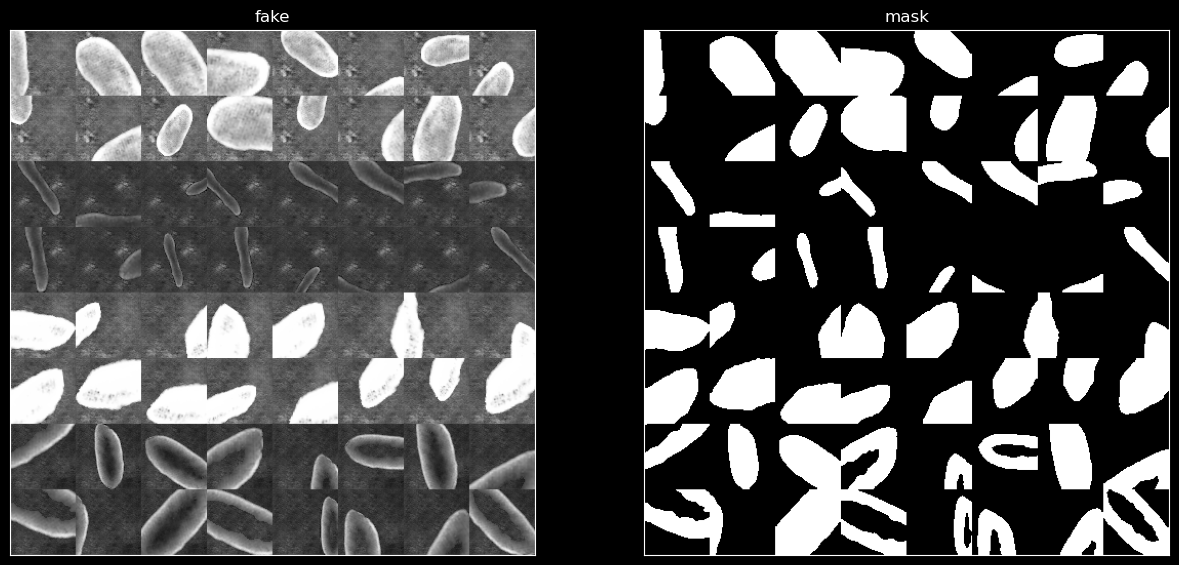

In [8]:
# demonstrate how it works
fake, mask = generate_bacteria_with_mask(batch_size=4, augmentation_count=16)
fake_grid = get_images_grid(fake, ncols=8)
mask_grid = get_images_grid(mask, ncols=8)
show_images([(fake_grid, "fake"), (mask_grid, "mask")], size_inches=(15, 15))

In [9]:
# generate and save images
_ = generate_bacteria_with_mask(
    iterations=1,
    batch_size=4,
    augmentation_count=4,
    save_images=True,
    bacterias_dir=TRAIN_FAKE_BACTERIAS_PATH,
    masks_dir=TRAIN_FAKE_MASKS_PATH,
)
_ = generate_bacteria_with_mask(
    iterations=1,
    batch_size=4,
    augmentation_count=4,
    save_images=True,
    bacterias_dir=TEST_FAKE_BACTERIAS_PATH,
    masks_dir=TEST_FAKE_MASKS_PATH,
)

Generated 16 bacterias with masks
Generated 16 bacterias with masks
